In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from kaggle_datasets import KaggleDatasets
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('shopee-product-detection-open')

# Configuration
EPOCHS = 30
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [4]:
!wc -l /kaggle/input/shopee-product-detection-open/train.csv

105391 /kaggle/input/shopee-product-detection-open/train.csv


In [5]:
train_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/train.csv')
test_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/test.csv')

train_df.shape, test_df.shape

((105390, 2), (12186, 2))

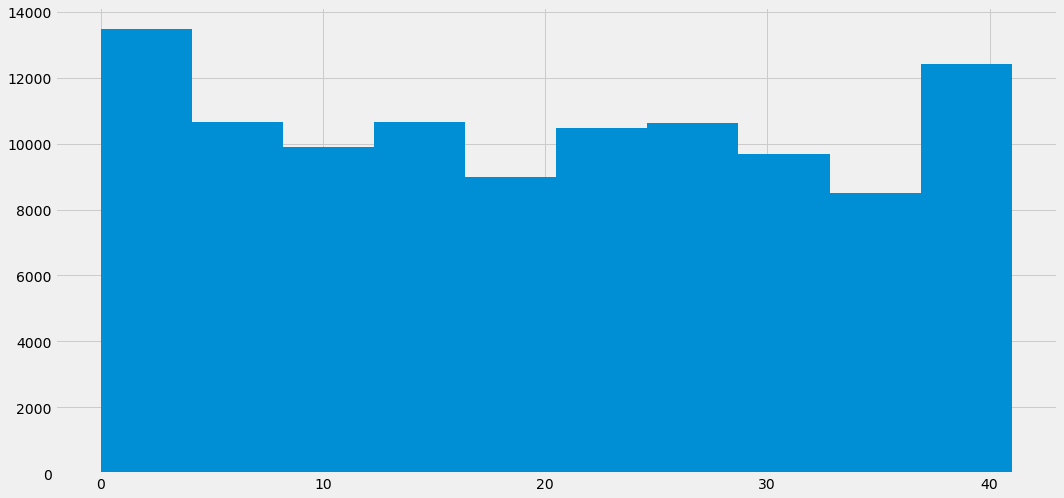

In [6]:
train_df.category.hist()

In [7]:
train_df_groupby_category = train_df.groupby(["category"]).count().max(level=0)
print(max(train_df_groupby_category.filename))
max_number_of_training_image = max(train_df_groupby_category.filename)

2705


In [8]:
train_df.head()

filename  category
0  45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg         3
1  f74d1a5fc2498bbbfa045c74e3cc333e.jpg         3
2  f6c172096818c5fab10ecae722840798.jpg         3
3  251ffd610399ac00fea7709c642676ee.jpg         3
4  73c7328b8eda399199fdedec6e4badaf.jpg         3

In [10]:
def show_train_img(category):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    train_path = '/kaggle/input/shopee-product-detection-open/train/train/train/'
    ten_random_samples = pd.Series(os.listdir(os.path.join(train_path, category))).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(train_path, category, image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

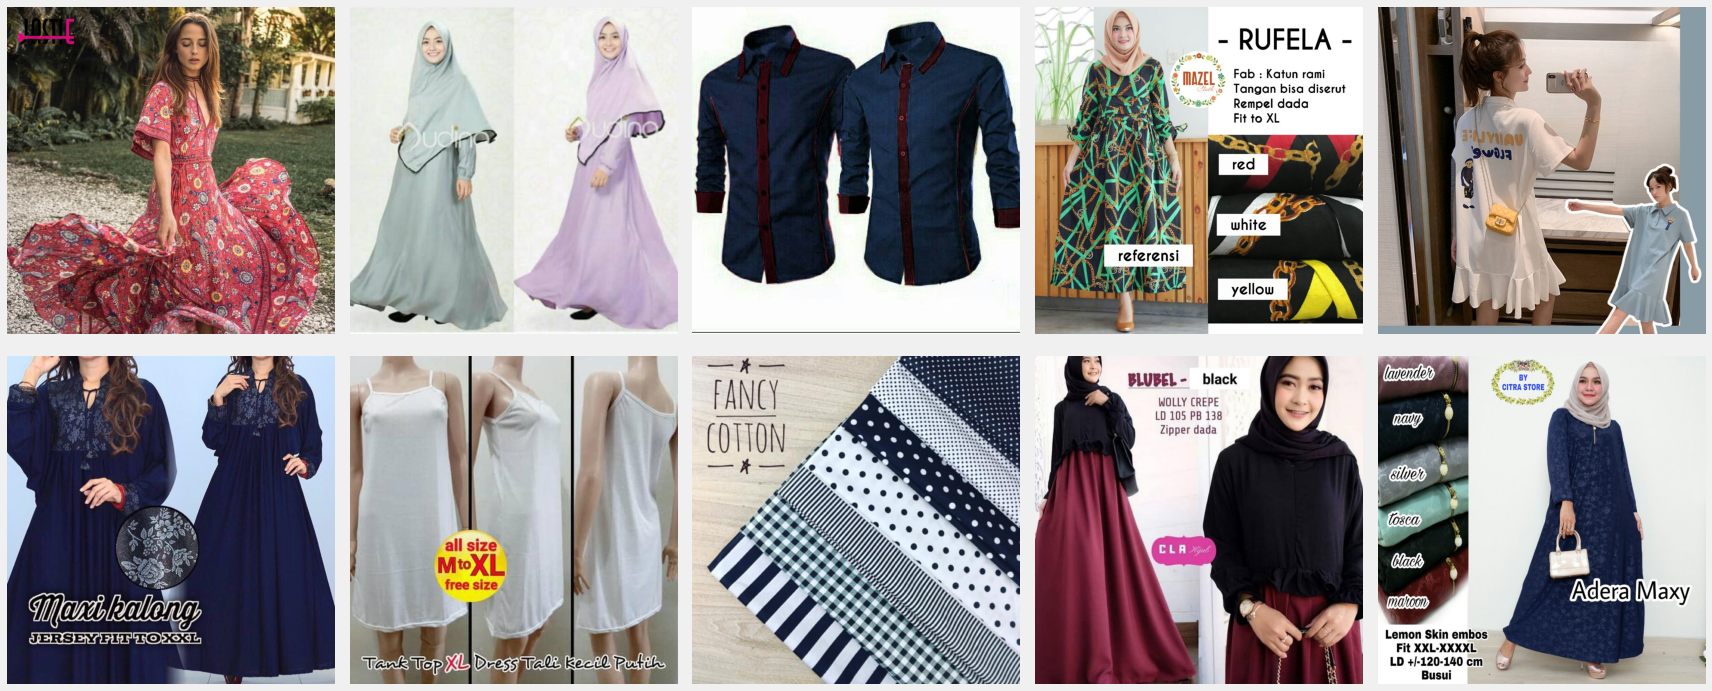

In [11]:
show_train_img('01')

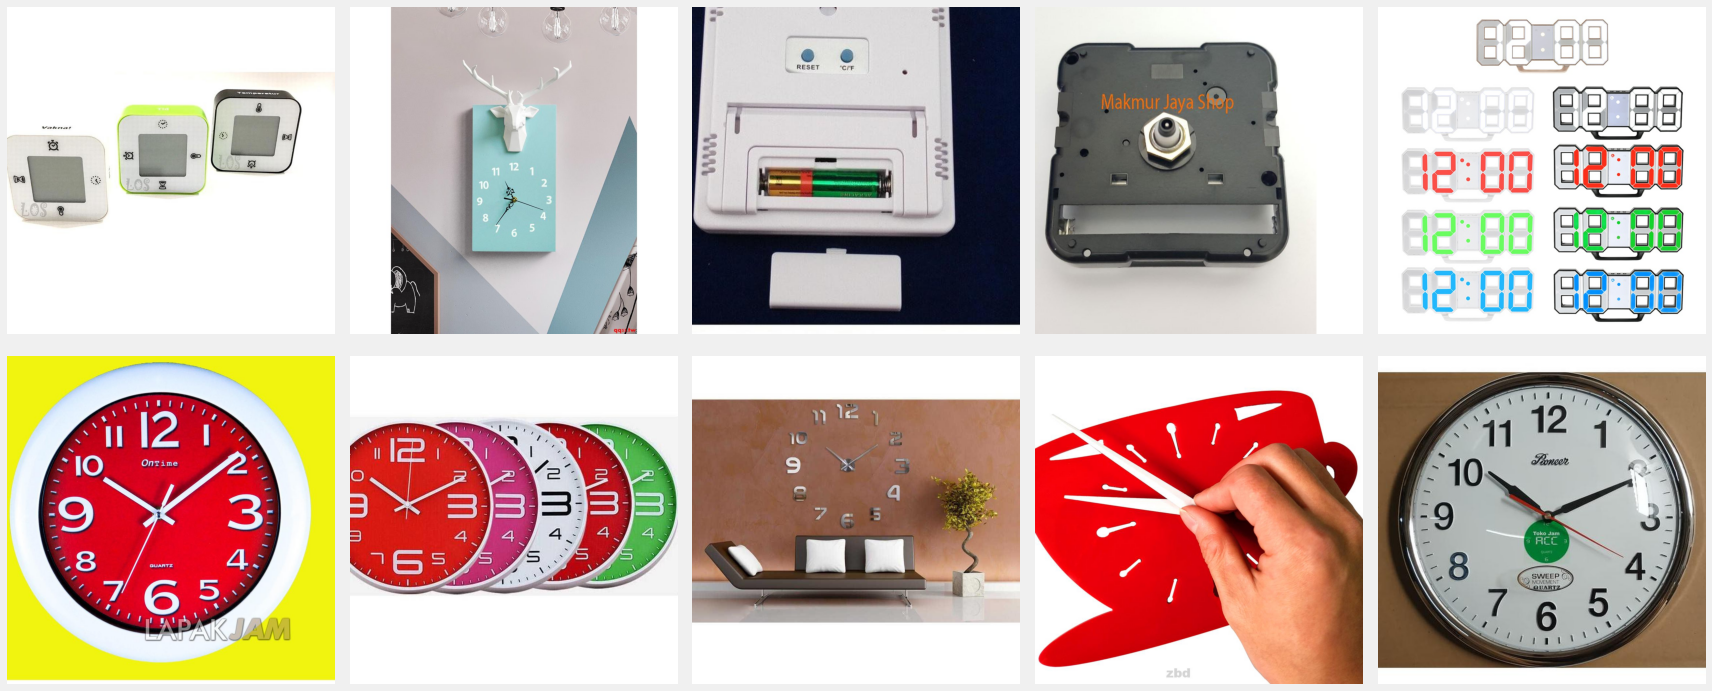

In [12]:
show_train_img('12')

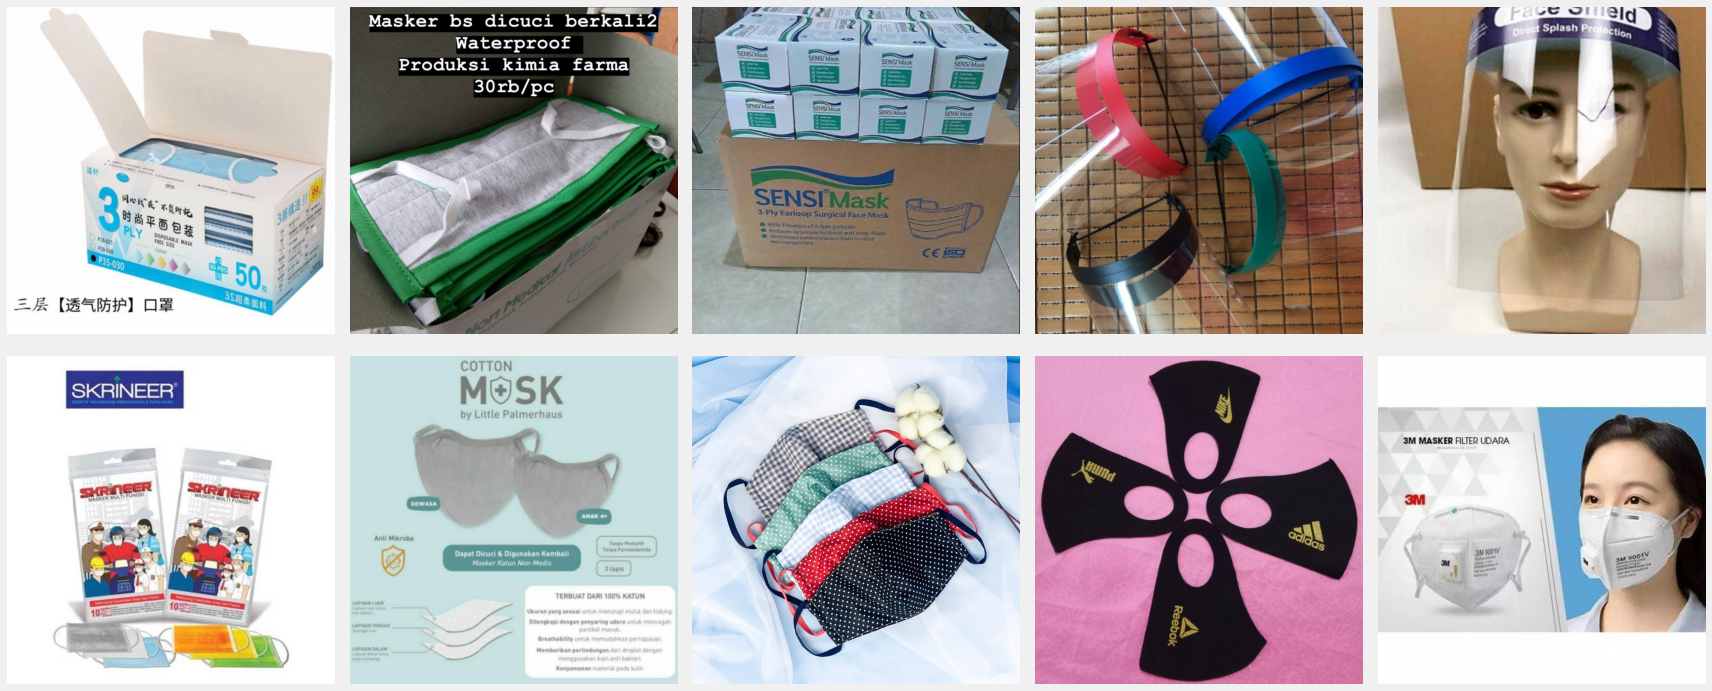

In [13]:
show_train_img('32')

<font size="+2" color="purple"><b>Show images in test dataset</b></font><br><a id="1"></a>

In [14]:
def show_test_img():
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    test_path = '/kaggle/input/shopee-product-detection-open/test/test/test/'
    ten_random_samples = pd.Series(os.listdir(test_path)).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(test_path, image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

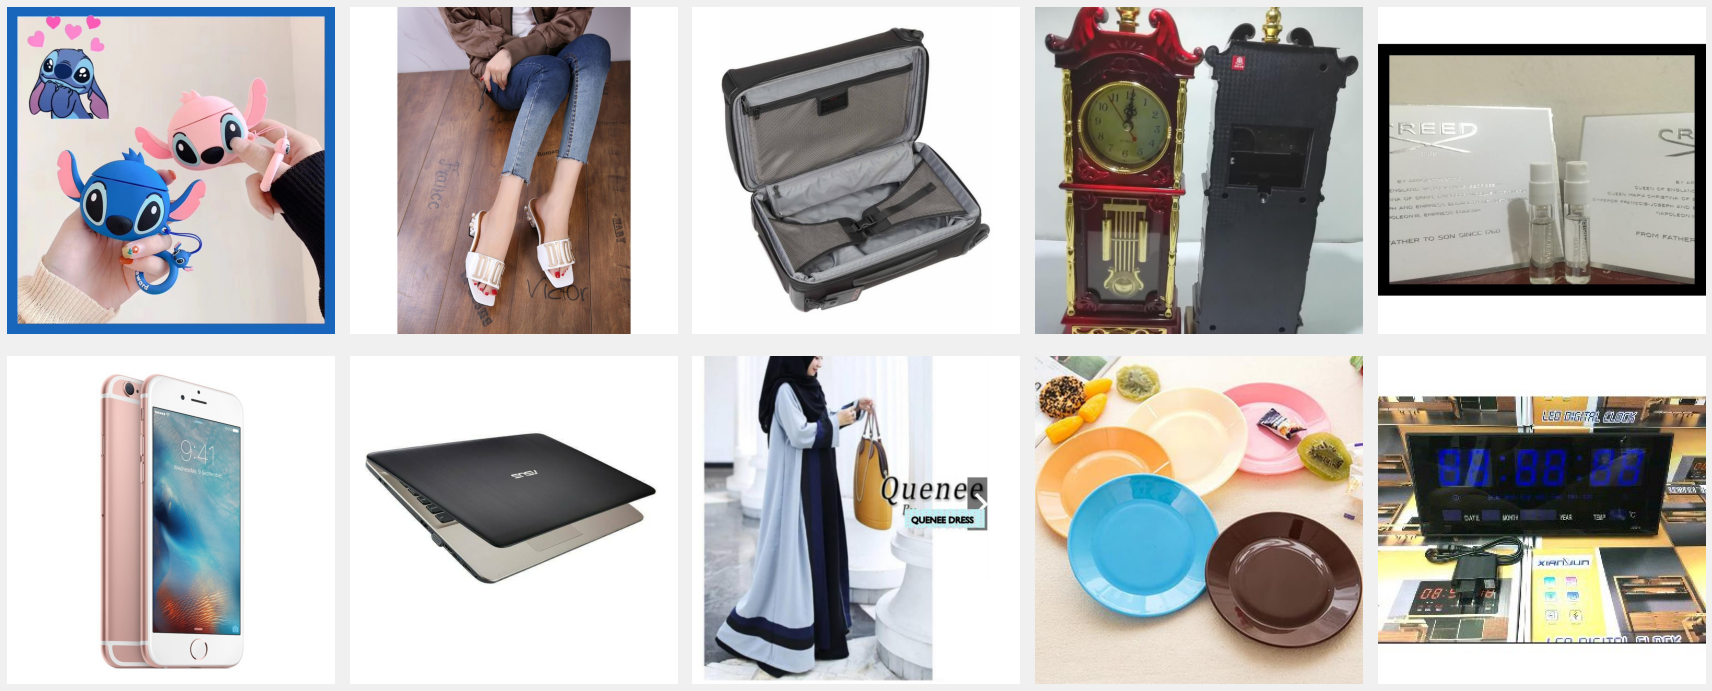

In [15]:
show_test_img()

# Balancing dataset

In [9]:
# pick random samples

dataset_path = {}

categories = np.sort(train_df['category'].unique())

for cat in categories:
#     try:
    dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(max_number_of_training_image,replace=True)
#         print ('Sampled category '+str(cat))
#     except:
#         #dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(frac=1.)
#         dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(max_number_of_training_image,replace=True)
    print ('Up-sampling for category '+str(cat))

Up-sampling for category 0
Up-sampling for category 1
Up-sampling for category 2
Up-sampling for category 3
Up-sampling for category 4
Up-sampling for category 5
Up-sampling for category 6
Up-sampling for category 7
Up-sampling for category 8
Up-sampling for category 9
Up-sampling for category 10
Up-sampling for category 11
Up-sampling for category 12
Up-sampling for category 13
Up-sampling for category 14
Up-sampling for category 15
Up-sampling for category 16
Up-sampling for category 17
Up-sampling for category 18
Up-sampling for category 19
Up-sampling for category 20
Up-sampling for category 21
Up-sampling for category 22
Up-sampling for category 23
Up-sampling for category 24
Up-sampling for category 25
Up-sampling for category 26
Up-sampling for category 27
Up-sampling for category 28
Up-sampling for category 29
Up-sampling for category 30
Up-sampling for category 31
Up-sampling for category 32
Up-sampling for category 33
Up-sampling for category 34
Up-sampling for category 35
Up

In [10]:
dataset_path[22]

100108    f00bbdf89b248213753633c7577bbdd6.jpg
100598    3864ec8fab0d5957aa529899dc2ad152.jpg
102089    379a498145eeba5a274c928fc66ad166.jpg
100205    2696407c6cfa346c92ac5fabc10fc49c.jpg
102599    a935487d104e32e8b6762476d1297906.jpg
                          ...                 
101984    6f04850029e2d1f3dc84e1b9960bc7a1.jpg
101940    23e113615a5131b9354e71db89a7ac96.jpg
100602    43f60a12596deb4c6d89ec65d4ffdf7a.jpg
101873    aee70f1ebec2d0396769a7c253a05b83.jpg
100260    45f701ff8c2e93cdd61cbc79d6f39e61.jpg
Name: filename, Length: 2705, dtype: object

In [11]:
category_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                 '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                 '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                 '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41']

In [12]:
train_paths = []

for idx, key in enumerate(dataset_path.keys()):
    if key == idx:
        for path in dataset_path[idx]:
            train_paths.append(os.path.join(GCS_DS_PATH, 'train', 'train', 'train', category_list[idx], path))

In [13]:
labels = []

for label in dataset_path.keys():
    labels.extend([label] * len(dataset_path[label]))

In [14]:
from tensorflow.keras.utils import to_categorical

# convert to numpy array
train_paths = np.array(train_paths)

# convert to one-hot-encoding-labels
train_labels = to_categorical(labels)

In [15]:
train_labels.shape

(113610, 42)

In [16]:
print(train_paths[10000])
print(np.argmax(train_labels[10000]))

gs://kds-8d22350d9fbf4ec1e7a5c02ef307251b33c5ef5dda6f376656736342/train/train/train/03/d9ca3f46f56411453febbf21e4bda031.jpg
3


In [17]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels, 
                                                                        stratify=train_labels,
                                                                        test_size=0.2, 
                                                                        random_state=2020)

train_paths.shape, valid_paths.shape, train_labels.shape, valid_labels.shape

((90888,), (22722,), (90888, 42), (22722, 42))

In [18]:
train_caption = []
for label in train_labels:
    train_caption.append(np.argmax(label))
valid_caption = []
for label in valid_labels:
    valid_caption.append(np.argmax(label))
#train_caption[1]
#train_paths[1]

In [19]:
f_data_train = open('train_path.csv','wt')
f_data_train.write('category,path\n')
for csv_rec in range(len(train_paths)):
    f_data_train.write(str(train_caption[csv_rec])+','+train_paths[csv_rec]+'\n')
f_data_train.close()

In [28]:
!sort -u train_path.csv | wc -l 
!grep ^0 train_path.csv | sort -u | wc -l 
!grep ^0 train_path.csv | wc -l 

60165
1498
2164


In [20]:
test_paths = []

for path in test_df['filename']:
    test_paths.append(os.path.join(GCS_DS_PATH,  'test', 'test', 'test', path))
    
test_paths = np.array(test_paths)

In [21]:
def decode_image(filename, label=None, image_size=(300, 300)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.per_image_standardization(image)
    image=(tf.math.subtract(image,  [0.485, 0.456, 0.406])/ [0.229, 0.224, 0.225])
    
    
    if label is None:
        return image
    else:
        return image, label

In [22]:
# decode_image(train_paths[10000])
# img = cv2.imread(decode_image(train_paths[10000]))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# axes.ravel()[idx].imshow(img)

In [23]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     image = tf.image.random_hue(image, max_delta=0.2)

    if label is None:
        return image
    else:
        return image, label

In [54]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [55]:
eraser = get_random_eraser(p=0.6)

In [56]:
def data_augment2(image, label=None):
    image = eraser(image)

    if label is None:
        return image
    else:
        return image, label

> You also can use gridmask / cutmix / mixup etc for experiment

In [57]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_caption))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .map(data_augment2, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_caption))
    .map(decode_image, num_parallel_calls=AUTO)
#     .map(data_augment2, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
#     .map(data_augment2, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [25]:
!pip install -q efficientnet

In [26]:
from tensorflow.keras.layers import Dense
from efficientnet.tfkeras import EfficientNetB4, EfficientNetB7

**Change to noisy-student and max pooling**

In [58]:
%%time 

with strategy.scope():
    model = tf.keras.Sequential([
        EfficientNetB4(weights='imagenet', # noisy-student, imagenet
                       include_top=False,
                       pooling='avg'), # avg, max
        Dense(512, activation='relu'),
        Dense(42, activation='softmax')
    ])
    
    model.layers[0].trainable = False
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 1792)              17673816  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               918016    
_________________________________________________________________
dense_7 (Dense)              (None, 42)                21546     
Total params: 18,613,378
Trainable params: 939,562
Non-trainable params: 17,673,816
_________________________________________________________________
CPU times: user 43.4 s, sys: 5.67 s, total: 49.1 s
Wall time: 45.9 s


In [59]:
n_steps = train_labels.shape[0] // BATCH_SIZE  # 86428 / 128 = 675

history = model.fit(
    train_dataset, 
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=5, 
    use_multiprocessing=True
)

Epoch 1/5
710/710 [==============================] - 2109s 3s/step - accuracy: 0.6044 - loss: 3.1865 - val_accuracy: 0.6809 - val_loss: 3.1010
Epoch 2/5
710/710 [==============================] - 89s 126ms/step - accuracy: 0.6672 - loss: 3.1155 - val_accuracy: 0.6932 - val_loss: 3.0872
Epoch 3/5
710/710 [==============================] - ETA: 0s - accuracy: 0.6844 - loss: 3.0974

KeyboardInterrupt: 

In [60]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
# model.save('my_model.h5')
from tensorflow.keras.models import save_model
print('Saving model...')
save_model_path = 'efficientnetB4_5epoch.hdf5'
save_model(model, save_model_path)
print('Done.')

Saving model...
Done.


In [38]:
from tensorflow.keras.models import load_model
print('Loading model...')
with strategy.scope():
#     model_path = KaggleDatasets().get_gcs_path('shopee-model/efficientnetB4_5epoch-4.hdf5')
    model = load_model('/kaggle/input/shopee-model/efficientnetB4_5epoch-4.hdf5')

Loading model...


In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [47]:
# Get training and test accuracy histories
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, accuracy, 'b--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Train Accuracy', 'Validate Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

NameError: name 'training_loss' is not defined

In [41]:
pred = model.predict(test_dataset, verbose=1)

96/96 [==============================] - 301s 3s/step


In [42]:
# # drop existing feature
test_df = test_df.drop('category', axis=1)

# # change with prediction
test_df['category'] = pred.argmax(axis=1)

# # then add zero-padding
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

In [43]:
test_df.to_csv('submission.csv', index=False)

## Make a submission with TTA

![tta](https://preview.ibb.co/kH61v0/pipeline.png)
source: [Test Time Augmentation (TTA) ... worth it?](https://www.kaggle.com/andrewkh/test-time-augmentation-tta-worth-it)

* TTA is simply to apply different transformations to test image like: rotations, flipping and translations.
* Then feed these different transformed images to the trained model and **average the results** to get more confident answer.

In [44]:
test_dataset_tta = (
        tf.data.Dataset
        .from_tensor_slices(test_paths)
        .map(decode_image, num_parallel_calls=AUTO)
        .cache()
        .map(data_augment, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
)

tta_times = 5
probabilities = []

for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(test_dataset_tta, verbose=1))
    
tta_pred = np.mean(probabilities, axis=0)

TTA Number:  0 

96/96 [==============================] - 243s 3s/step
TTA Number:  1 

96/96 [==============================] - 9s 98ms/step
TTA Number:  2 

96/96 [==============================] - 9s 98ms/step
TTA Number:  3 

96/96 [==============================] - 9s 93ms/step
TTA Number:  4 

96/96 [==============================] - 9s 95ms/step
TTA Number:  5 

96/96 [==============================] - 9s 95ms/step


In [45]:
# change with prediction
test_df['category'] = tta_pred.argmax(axis=1)

# then add zero-padding
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

In [46]:
test_df.to_csv('sub_with_tta.csv', index=False)

In [47]:
test_df.head()

filename category
0  fd663cf2b6e1d7b02938c6aaae0a32d2.jpg       20
1  c7fd77508a8c355eaab0d4e10efd6b15.jpg       27
2  127f3e6d6e3491b2459812353f33a913.jpg       04
3  5ca4f2da11eda083064e6c36f37eeb81.jpg       22
4  46d681a542f2c71be017eef6aae23313.jpg       12

# Reference:

[EfficientNet from Google — Optimally Scaling CNN model architectures with “compound scaling”](https://medium.com/@lessw/efficientnet-from-google-optimally-scaling-cnn-model-architectures-with-compound-scaling-e094d84d19d4)

[Image Classification with EfficientNet: Better performance with computational efficiency](https://medium.com/analytics-vidhya/image-classification-with-efficientnet-better-performance-with-computational-efficiency-f480fdb00ac6)

[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://medium.com/@nainaakash012/efficientnet-rethinking-model-scaling-for-convolutional-neural-networks-92941c5bfb95)